In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

questo con una personal CNN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import os
from torch.utils.data import ConcatDataset

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
import numpy as np
import seaborn as sns

In order to set-up the dataset I had to download if folllowing an online procedure. 
The dataset was dismissed by torchivision and is not more available.

The directory structure should be:

└── stanford_cars 
    └── cars_test_annos_withlabels.mat 
    └── cars_train
        └── *.jpg
    └── cars_test
        └── .*jpg
    └── devkit
        ├── cars_meta.mat
        ├── cars_test_annos.mat
        ├── cars_train_annos.mat
        ├── eval_train.m
        ├── README.txt
        └── train_perfect_preds.txt

In [5]:
# Load the dataset
dataset = torchvision.datasets.StanfordCars(root="./")

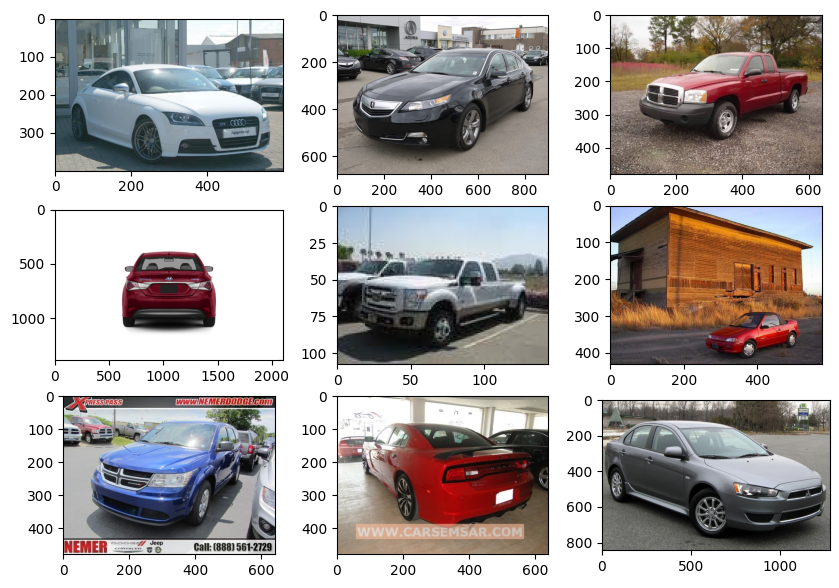

In [6]:
# Display some random images of the dataset
fig, ax = plt.subplots(3, 3, figsize=(10, 7))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(dataset[i * 3 + j][0])
        ax[i, j].axis("on")
plt.show()

changes this part 

In [7]:
# Define transformations for training and validation sets
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.StanfordCars(root="./", split='train', transform=transform_train)
val_dataset = datasets.StanfordCars(root="./", split='test', transform=transform_val)

# Original dataset without augmentations
transform_original = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Original training dataset
train_dataset_original = datasets.StanfordCars(root="./", split='train', transform=transform_original)

# Combined dataset with both original and augmented images
combined_train_dataset = ConcatDataset([train_dataset, train_dataset_original])

# Create data loaders
train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

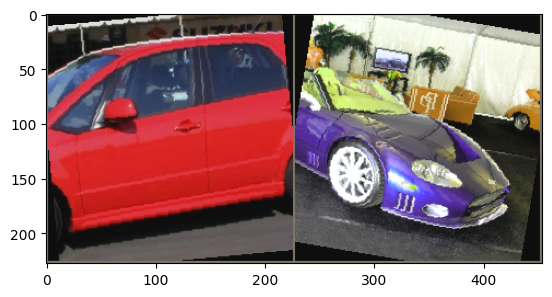

In [8]:
# Display some augmented images from the training set
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def show_augmented_images(dataloader):
    inputs, classes = next(iter(dataloader))
    out = torchvision.utils.make_grid(inputs)
    imshow(out)

# Create a DataLoader for visualization with a small batch size
vis_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Display some augmented images
show_augmented_images(vis_loader)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=196):  # Stanford Cars has 196 classes
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Flattened size will be determined dynamically
        self.flattened_size = None
        
        # Fully connected layers (defined later)
        self.fc1 = None
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        # Dynamically determine the flattened size if not set
        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flattened_size, 4096).to(x.device)
        
        # Flatten the tensor before passing it to the fully connected layers
        x = x.view(-1, self.flattened_size)
        
        # Fully connected layers with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x

# Instantiate the model and move to device
model = SimpleCNN(num_classes=196)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = model.to(device)

print(f"Using device: {device}")
print(f"Device: {device}")

Using device: mps
Device: mps


In [10]:
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=196, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
# Function to create a new run directory
def create_new_run_dir(base_log_dir):
    run_number = 0
    while os.path.exists(os.path.join(base_log_dir, f"{run_number:04d}")):
        run_number += 1
    new_run_dir = os.path.join(base_log_dir, f"{run_number:04d}")
    os.makedirs(new_run_dir)
    return new_run_dir

# Base log directory
base_log_dir = "./runs/StanfordCars/"

# Create a new run directory
log_dir = create_new_run_dir(base_log_dir)
writer = SummaryWriter(log_dir)

In [13]:
num_epochs = 50

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(combined_train_dataset)
    epoch_acc = running_corrects.float() / len(combined_train_dataset)

    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/train', epoch_acc, epoch)
    
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_dataset)
    val_acc = val_corrects.float() / len(val_dataset)

    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)
    
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Step the scheduler
    scheduler.step()

# Close the TensorBoard writer
writer.close()

Epoch 1/50
Train Loss: 5.2824 Acc: 0.0070
Val Loss: 5.2742 Acc: 0.0085
Epoch 2/50
Train Loss: 5.2779 Acc: 0.0082
Val Loss: 5.2732 Acc: 0.0085
Epoch 3/50
Train Loss: 5.2766 Acc: 0.0083
Val Loss: 5.2728 Acc: 0.0085
Epoch 4/50
Train Loss: 5.2767 Acc: 0.0083
Val Loss: 5.2730 Acc: 0.0085
Epoch 5/50
Train Loss: 5.2768 Acc: 0.0082
Val Loss: 5.2727 Acc: 0.0085
Epoch 6/50


python(54387) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54389) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54390) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54391) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 5.2771 Acc: 0.0083


python(54669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54671) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54672) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54675) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Val Loss: 5.2725 Acc: 0.0085
Epoch 7/50


python(54753) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54756) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54758) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54760) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Train Loss: 5.2782 Acc: 0.0083


python(55075) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55078) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55080) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55081) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Val Loss: 5.2726 Acc: 0.0085
Epoch 8/50


python(55161) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55164) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55165) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55166) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
torch.save(model.state_dict(), 'trained_model7.pth')

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Lists to store true labels and predictions
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

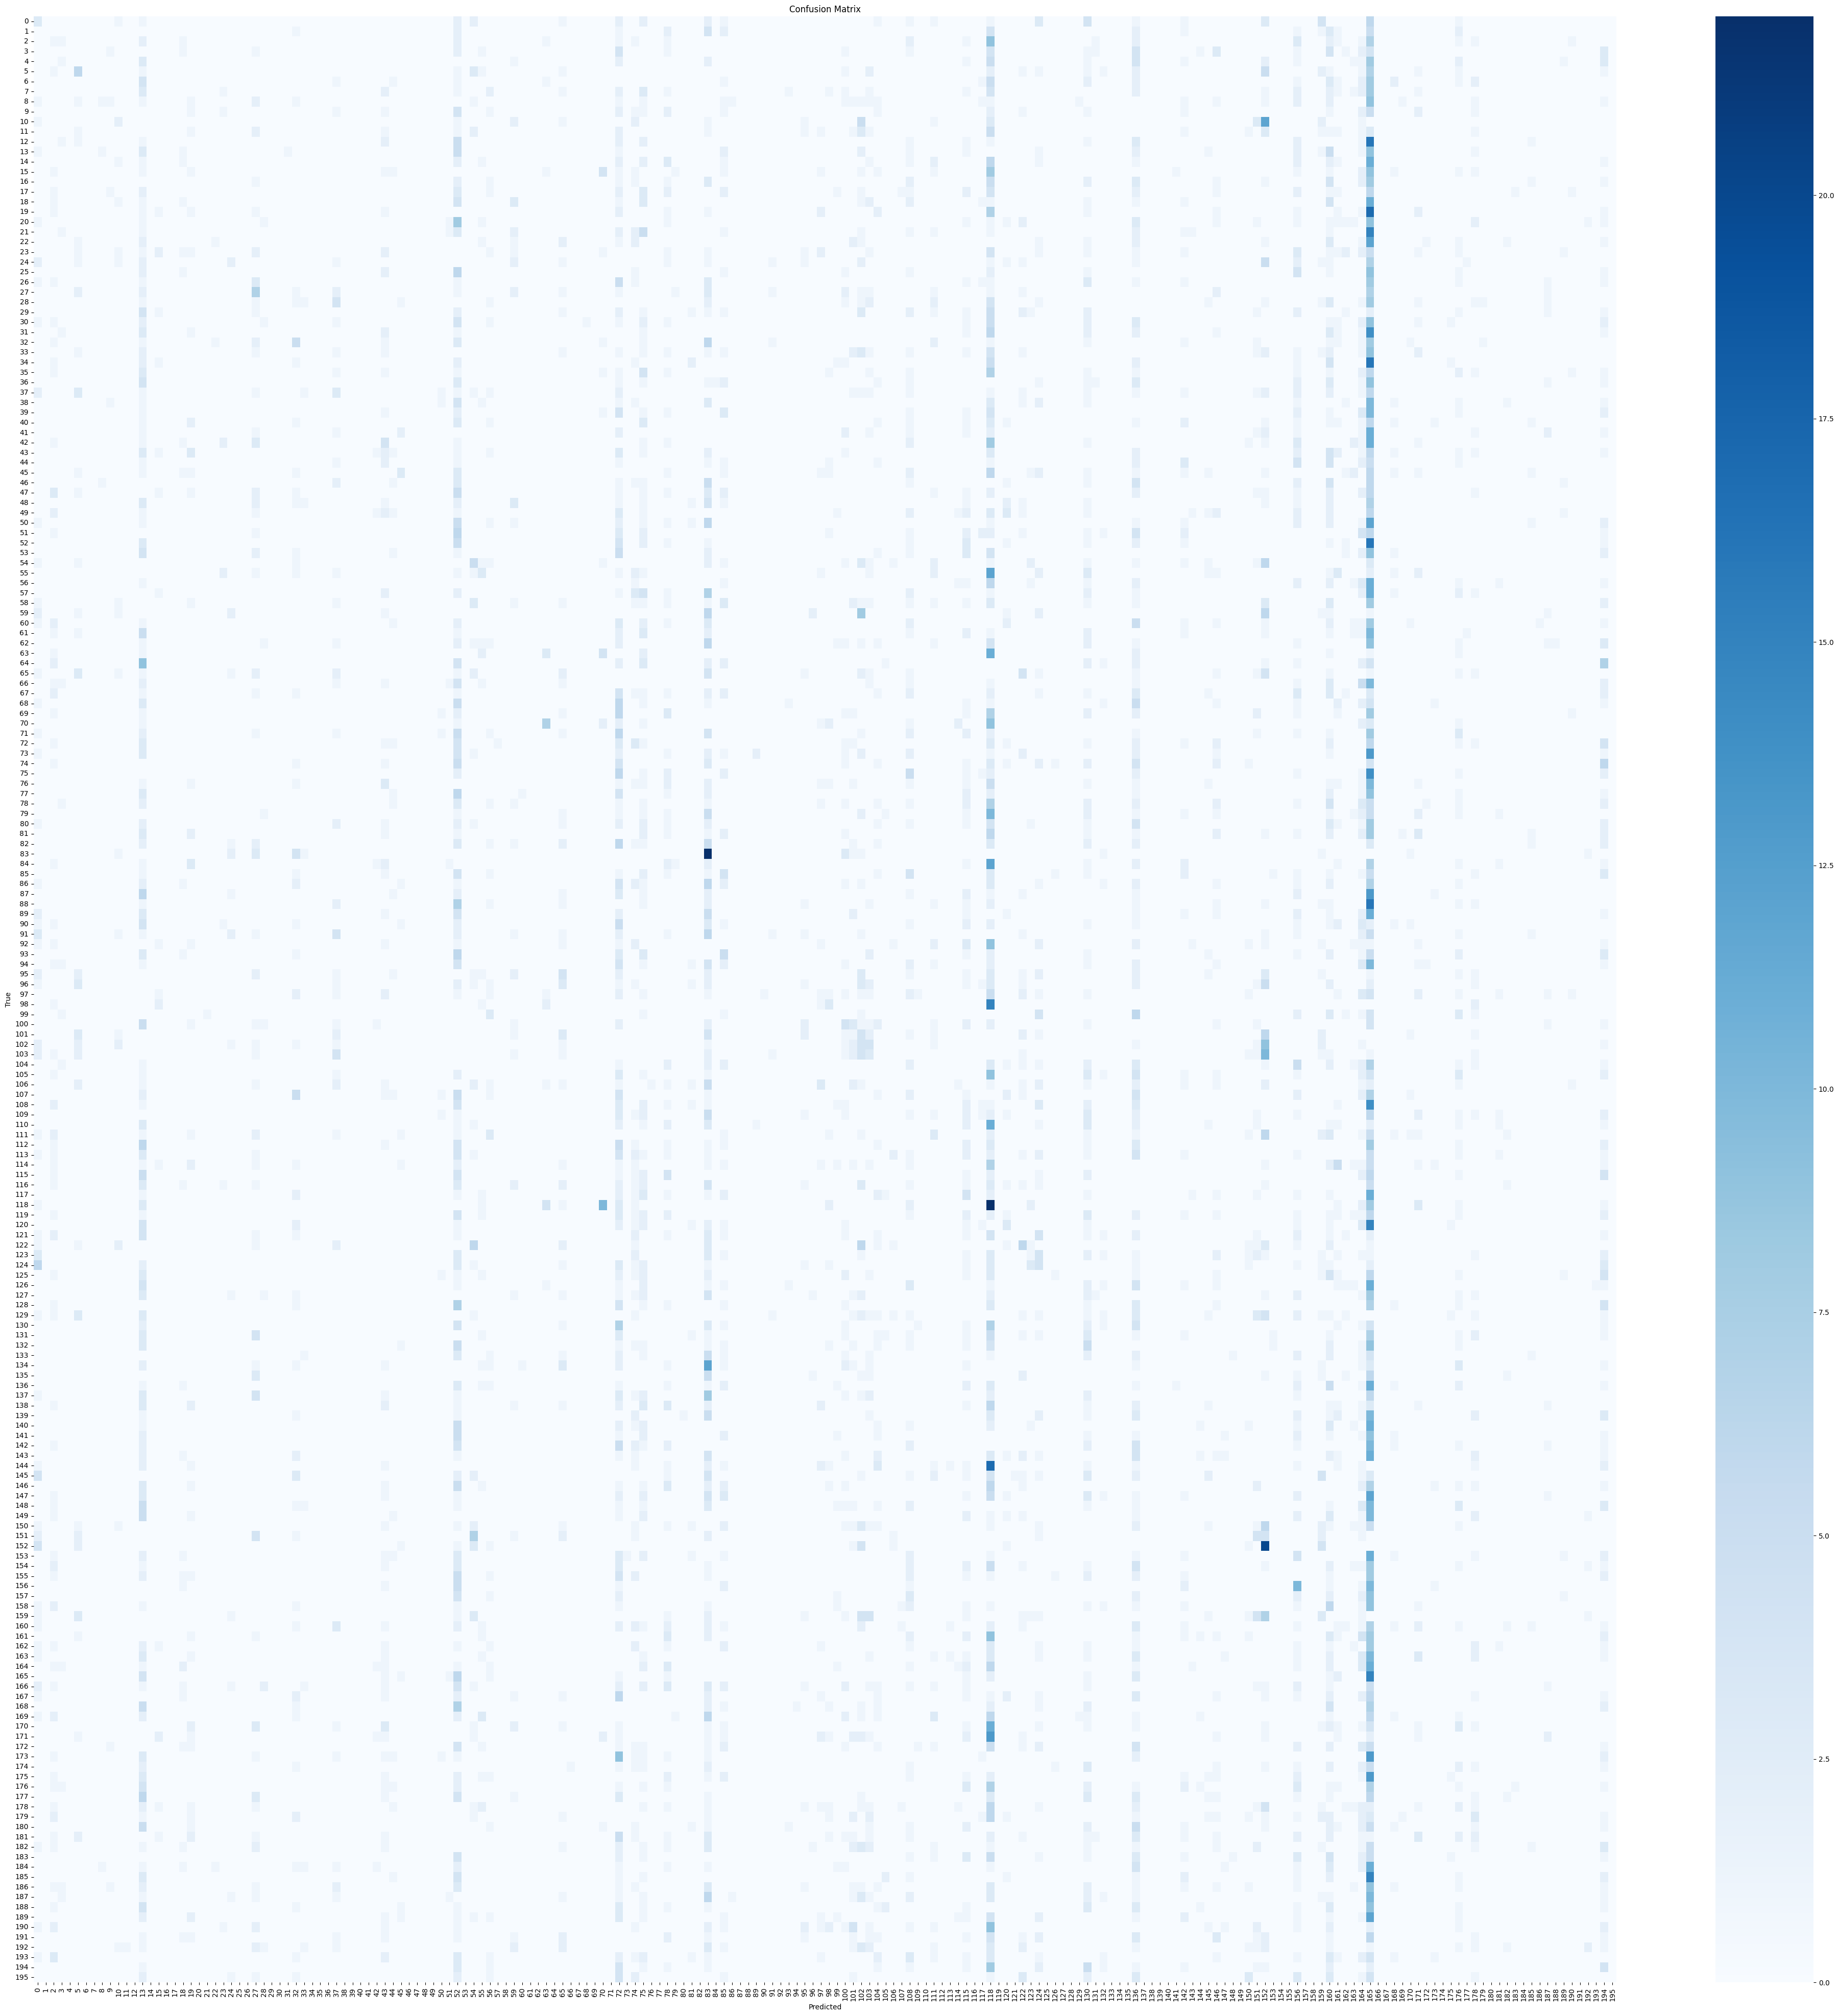

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(50, 50))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=range(196), yticklabels=range(196))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

# Function to show an image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of validation data
inputs, labels = next(iter(val_loader))
inputs, labels = inputs.to(device), labels.to(device)

# Forward pass to get predictions
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Define a list of class names if available
class_names = [str(i) for i in range(196)]  # Modify this with actual class names if available

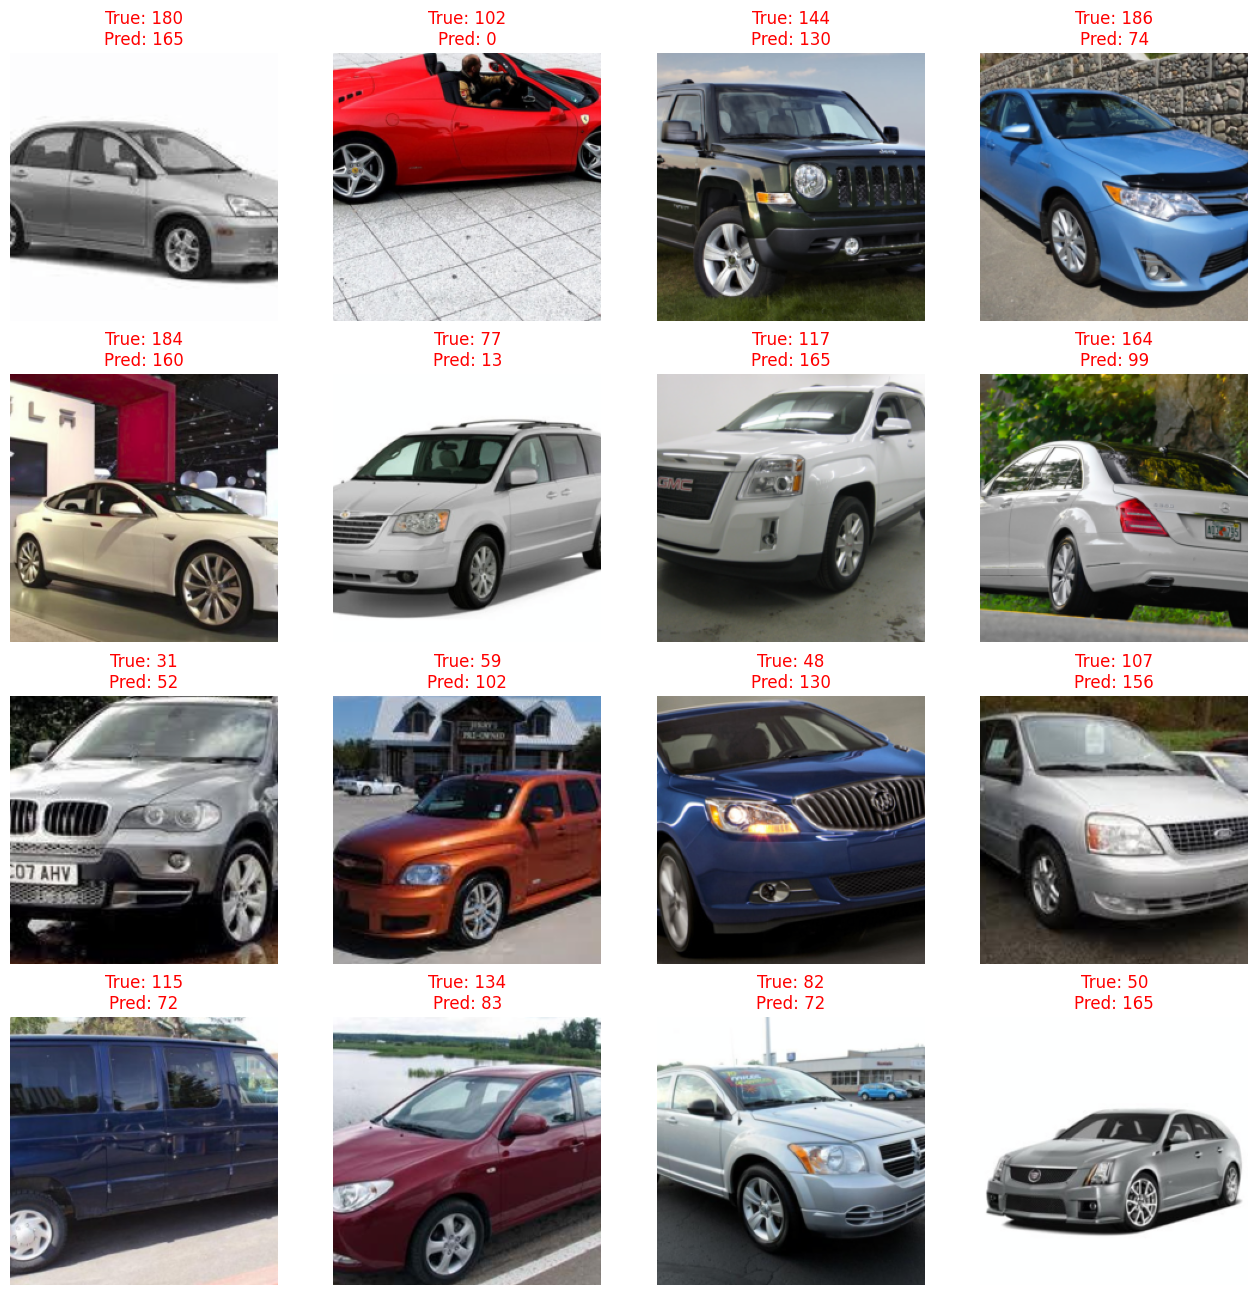

In [ ]:
# Display images with predictions and true labels
plt.figure(figsize=(16, 16))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    imshow(inputs.cpu().data[i])
    true_label = class_names[labels[i].item()] if class_names else labels[i].item()
    pred_label = class_names[preds[i].item()] if class_names else preds[i].item()
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=("green" if true_label == pred_label else "red"))
    ax.axis('off')

plt.show()